# Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data is provided by Bertelsmann Arvato Analytics.

### Main Steps:
- Load Package and Data
- Data Preprocessing
   - Assess Missing Data (cols/rows)
   - Select and Re-Encode Features (categorical/mixed-type features)
   - Missing Data Imputation
   - Create Overall Cleaning Function
- Feature Transformation
   - Apply Feature Scaling
   - Perform Dimensionality Reduction (**PCA**)
   - Interpret Principal Components
- Clustering (**K-means**)
   - Apply Clustering to General Population 
   - Apply All Steps to the Customer Data
   - Compare Customer Data to Demographics Data
   - Interpret the Difference
- Conclusion

> **Note**: First, I will examine the demographic data, and then create a cleaning function to process the same procedures to customer data. 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from __future__ import print_function

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer

## Step 0: Load the Data

Data Files:
- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

In [2]:
# General demographics data.
azdias = pd.read_csv("AZDIAS_Subset.csv", sep=';')

# Cumstomer data.
customer = pd.read_csv("CUSTOMERS_Subset.csv",sep=';')

In [3]:
# Feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')
feat_info.head(3)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


In [4]:
# Display all columns and rows
pd.set_option('display.max_columns',250)
pd.set_option('display.max_rows',250)

In [5]:
# Check the structure of the data
print("AZDIAS Subset has {} rows, {} columns".format(azdias.shape[0],azdias.shape[1]))
azdias.head(3)  # print the first 3 rows

AZDIAS Subset has 891221 rows, 85 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [6]:
print("CUSTOMERS Subset has {} rows, {} columns".format(customer.shape[0],customer.shape[1]))
customer.head(3)  # print the first 3 rows

CUSTOMERS Subset has 191652 rows, 85 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

First, assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. The file encodes this as a list (e.g. `[-1,0]`). First, I convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value.

In [7]:
def check_nan(x,check_list):
    '''
    Check NaN in feature info
    '''
    nans=[]
    for val in check_list:
        nans.append(x==val)
        try:
            nans.append(float(x)==float(val))
        except:
            pass
    return any(nans)

In [8]:
def replace_nan(df):
    '''
    Identify missing or unknown data values and convert them to NaNs
    '''
    for i, feature in enumerate(df.columns):
        l =  feat_info.missing_or_unknown[i][1:-1].split(',')
        nan_list=df[feature].astype(str).apply(check_nan, check_list=l)
        df[feature][nan_list]=np.nan
    return df   

In [9]:
azdias = replace_nan(azdias)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
print(azdias.shape)
azdias.head(2)

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


#### Step 1.1.2: Assess Missing Data in Each Column

There are a few columns that are outliers in terms of the proportion of values that are missing. Use [`matplotlib`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data.

In [11]:
# count number of missing in a column 
missing_by_column = azdias.isnull().sum()

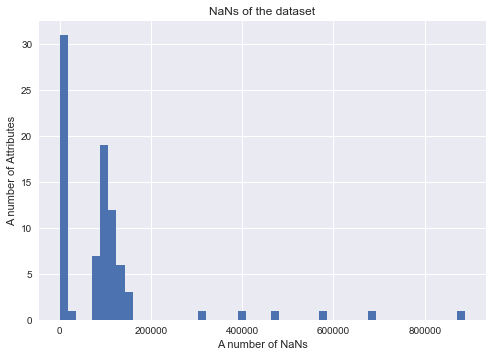

In [12]:
# Investigate patterns in the amount of missing data in each column.
missing_by_column.hist(bins=50, grid=True)
plt.title('NaNs of the dataset')
plt.xlabel('A number of NaNs')
plt.ylabel('A number of Attributes')
plt.show()

**Complete Variables**
"FINANZ"/"FINANZTYP" (financial typology) and "SEMIO" (Personality typology) feature sets are complete. In addition, "ANREDE_KZ" (gender), "GREEN_AVANTGARDE"(Membership in environmental sustainability as part of youth), and "ZABEOTYP"(Energy consumption typology) are complete. 

**Drop Variables**
Azdias has 891,221 data points. Most columns have less than 200,000 (>20%) missing values. I drop columns with over 200,000 missing values. The dropped columns are shown below. They are also correlated with other features. So some other features can reflect some characteristics of those dropped features. 

In [13]:
print(missing_by_column[missing_by_column > 200000])

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64


In [14]:
def drop_column(df):
    '''
    Remove columns with too many missing values
    '''
    col_d=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    df = df.drop(col_d,axis=1)
    return df

In [15]:
azdias = drop_column(azdias)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

**Patterns in Missing values**
azdias had 891221 data points. Most columns have less than 200,000 missing values. I will drop columns with over 200,000 missing values and imputate the missings in the rest columns. There are 5 columns having more than 20,000 missing values (over 20%). The **Drop Columns** are:
- AGER_TYP        685843; 
- GEBURTSJAHR     392318; 
- TITEL_KZ        889061; 
- ALTER_HH        310267; 
- KK_KUNDENTYP    584612; 
- KBA05_BAUMAX    476524.

For those columns with too many missing values, they can be reflected by other features in the database. 

#### Step 1.1.3: Assess Missing Data in Each Row

Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should pay attention if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups.

Select at least five of these columns and compare the distribution of values (seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html).)

If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special.

In [16]:
# How much data is missing in each row of the dataset?
n_col = len(azdias.columns)
azdias['missing_by_row'] = azdias.apply(lambda x: n_col-x.count(), axis=1)

In [17]:
print(azdias['missing_by_row'].describe())

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: missing_by_row, dtype: float64


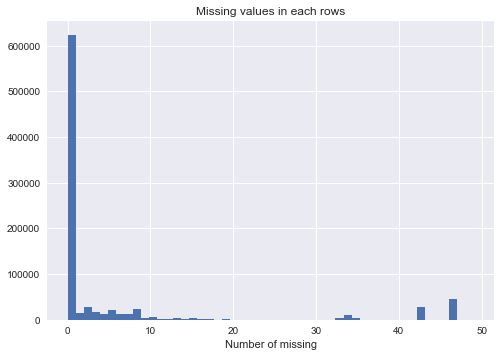

In [20]:
azdias['missing_by_row'].hist(bins=50, grid=True)
plt.title('Missing values in each rows')
plt.xlabel('Number of missing')
plt.show()

In [21]:
# Divide the data into two subsets based on the number of missing values in each row.
# sub1 with no missing values & sub2 with some missings
azdias_sub1 = azdias.loc[azdias['missing_by_row'] == 0]  
azdias_sub2 = azdias.loc[azdias['missing_by_row'] > 0]

In [22]:
print(azdias_sub1.shape)  # subset with no missing
print(azdias_sub2.shape)

(623209, 80)
(268012, 80)


In [23]:
azdias_sub1 = azdias_sub1.drop(['missing_by_row'], axis=1)
azdias_sub2 = azdias_sub2.drop(['missing_by_row'], axis=1)

The created azdias_sub1 has no missing values. The azdias_sub2 has some missing values. The sub_1 takes around 3/4 total data. 

In [24]:
def drop_rows(df):
    '''
    Remove rows with missing value(s)
    '''
    n_col = len(df.columns)
    df = df[df.apply(lambda x: n_col-x.count(),axis=1)==0] # define the missing level=0
    return df

In [25]:
def plot_missing(df):
    '''
    To examine whether there is any missing values in the database;
    Plot percent of missing values in each column
    '''
    num_nans = pd.DataFrame(df.isnull().sum()/len(df),columns=['n_nan',])
    num_nans = num_nans[num_nans.n_nan>0]
    num_nans = num_nans.sort_values(by='n_nan')
    n = num_nans.count()[0]
    if n>0:
        plt.figure(figsize=(10,10))
        plt.barh(range(len(num_nans)),num_nans.n_nan.tolist())
        t = plt.yticks(range(len(num_nans)),num_nans.n_nan.index.tolist())
        plt.title('Missing values in each rows')
        plt.xlabel('Number of missing')
        plt.show()
        print(num_nans.tail(5))
    else:
        print('The dataset has no missing value.')      

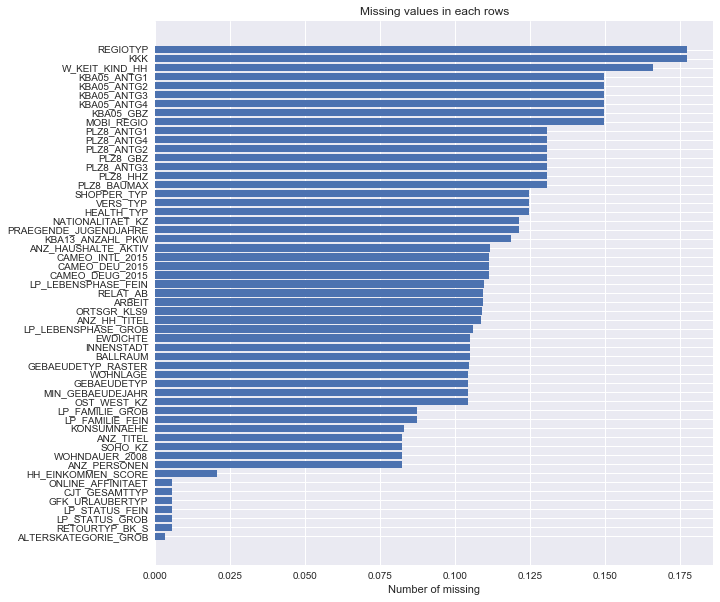

                   n_nan
KBA05_ANTG2     0.149597
KBA05_ANTG1     0.149597
W_KEIT_KIND_HH  0.166051
KKK             0.177357
REGIOTYP        0.177357


In [26]:
# The missing proportion in overall database
plot_missing(azdias)

In [27]:
plot_missing(azdias_sub1)

The dataset has no missing values


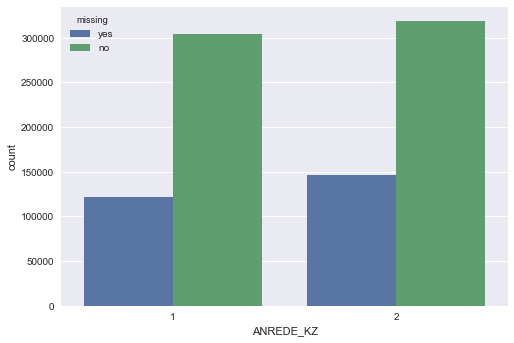

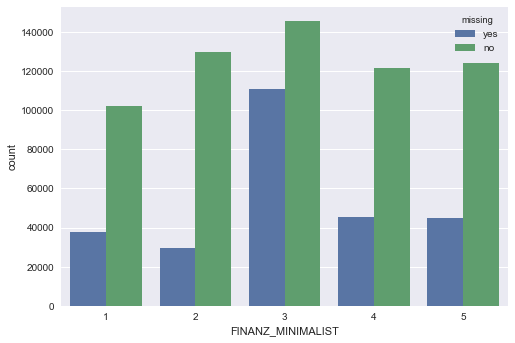

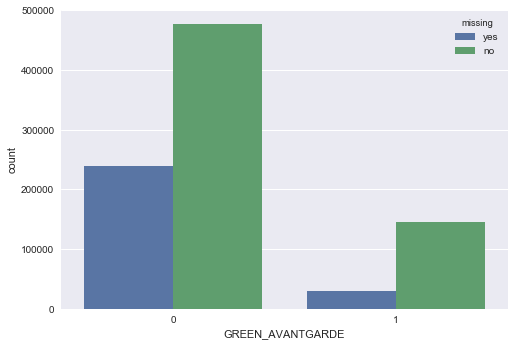

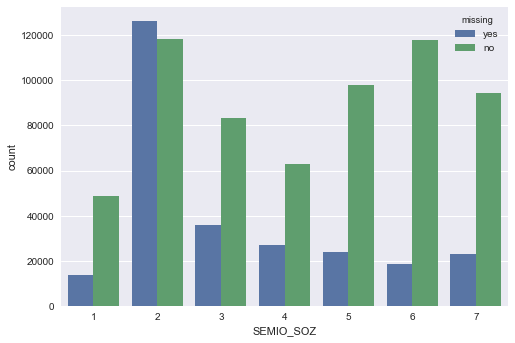

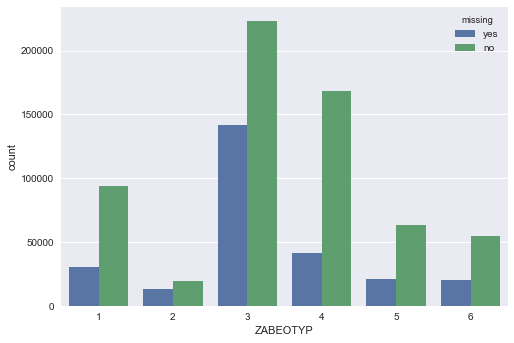

In [28]:
# Compare the distribution of values between the two subsets.
azdias['missing'] = np.where(azdias['missing_by_row']==0, 'no', 'yes')

def plot_compare(dframe,colnames):
    for colname in colnames:
        sns.countplot(x=colname,data=dframe,hue="missing")
        plt.show()

plot_compare(azdias,['ANREDE_KZ','FINANZ_MINIMALIST','GREEN_AVANTGARDE','SEMIO_SOZ','ZABEOTYP'])

#### Discussion 1.1.3: Assess Missing Data in Each Row

As mentioned above, if the distributions of non-missing features look very different from the data with many missing values, then we should make a note on those data as special.

The data with missing values are qualitatively different from data with no missing values. We need to **keep sub2 aside** (the subset with missing values). We have over 60,000 data with no missing values (after dropping columns with too many missings), over 3/4 of the total dataset, which is large enough to detect the patterns. So I decide to use the subset 1 with no missing values in the following analysis. 

Another way to work here is using "Imputation" to make up missing data in each rows. 

**Reference About Imputation**: 
    - A constant value that has meaning within the domain, such as 0, distinct from all other values.
    - A value from another randomly selected record.
    - A mean, median or mode value for the column. 
    - A value estimated by another predictive model (Regression, K-Nearest Neighbours, etc).

Some common ways to impute missing values ([`link`](https://stackoverflow.com/questions/35680426/missing-value-in-data-analysis)).

Wiki article on data imputation ([`link`](https://en.wikipedia.org/wiki/Imputation_(statistics))).

Simple Imputer ([`link`](http://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer))

### Step 1.2: Select and Re-Encode Features

#### Check Categorical and Mixed-type features

Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [29]:
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')
feat_info.groupby('type', axis=0).count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, encode the levels as dummy variables. 
- For binary variable that takes numeric values, no change.
- For binary variable that takes non-numeric values, re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals, encode by multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html))

In [30]:
# Extract categorical data list, and remove those dropped columns. 
cate_list = feat_info[feat_info.type=='categorical'].attribute.tolist()
drop_column=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
cate_list = [x for x in cate_list if x not in drop_column]
print(cate_list)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [31]:
# Examine the categorical list
for var in cate_list:
    print(var,azdias_sub1[var].unique())

ANREDE_KZ [2 1]
CJT_GESAMTTYP [5. 3. 2. 4. 1. 6.]
FINANZTYP [1 5 2 4 6 3]
GFK_URLAUBERTYP [10.  5.  1. 12.  9.  3.  8. 11.  4.  7.  6.  2.]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [3. 1. 5. 2. 4.]
LP_STATUS_FEIN [ 2.  3.  4.  1. 10.  9.  5.  6.  7.  8.]
LP_STATUS_GROB [1. 2. 5. 4. 3.]
NATIONALITAET_KZ [1. 2. 3.]
SHOPPER_TYP [3. 2. 0. 1.]
SOHO_KZ [1. 0.]
VERS_TYP [2. 1.]
ZABEOTYP [5 4 1 6 3 2]
GEBAEUDETYP [8. 1. 3. 5.]
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '6' '2' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '1B' '8B'
 '7A' '3D' '4E' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '5C' '9C' '7D' '5E'
 '1D' '8D' '6C' '5B' '7C' '4D' '3A' '2B' '7E' '4B' '2A' '3B' '6F' '5F'
 '1C' '6A']


In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.
def category_var(df):
    '''
    Deal with all Categorical Variables
    '''
    cate_list = feat_info[feat_info.type=='categorical'].attribute.tolist()
    for var in cate_list:
        if var in df.columns:
            df[var]=df[var].astype('category')
        else:
            cate_list.remove(var)
            
    cate_list.remove('GREEN_AVANTGARDE')
    cate_list.remove('SOHO_KZ')
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    cate_list.remove('OST_WEST_KZ')

    df.ANREDE_KZ[df.ANREDE_KZ == 2] = 0  # 1: Male; 2->0:Female
    df.VERS_TYP[df.VERS_TYP == 2] = 0    # 1: social-safety driven; 2->0: individualistic-accepting risks
    cate_list.remove('ANREDE_KZ')
    cate_list.remove('VERS_TYP')
    
    df = pd.get_dummies(df,columns=cate_list)
    return df   

In [33]:
azdias_new = category_var(azdias_sub1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
print(azdias_new.shape)
azdias_new.head(2)

(623209, 191)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_3.0,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,0,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,0.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3.0,0,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

#### Discussion 1.2.1: Re-Encode Categorical Features

All dropped columns are removed from categorical list before get dummies. 

**Binary**: ANREDE_KZ; GREEN_AVANTGARDE; SOHO_KZ; VERS_TYP; OST_WEST_KZ. Since "GREEN_AVANTGARDE" and "SOHO_KZ" are dummies with 0/1, do not need to encode again. "ANREDE_KZ" and "VERS_TYP" changed to 0/1 binary. "OST_WEST_KZ" is encoded as numbers instead of letters. 

When using "get_dummies", the original variable is automatically dropped. 

#### Step 1.2.2: Engineer Mixed-Type Features

In [35]:
# List all mixed features in the data and check them in Dictionary
mixed_list = feat_info[feat_info.type=='mixed'].attribute.tolist()
drop_column=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
mixed_list = [x for x in mixed_list if x not in drop_column]
print(mixed_list)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


##### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

In [36]:
def generation(x):
    '''Define Generation 
    '''
    age_list = [[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,15]]
    for idx, lst in enumerate(age_list):
        ret = [x==i for i in lst]
        if any(ret):
            return idx      

def movement(x):
    '''Define movement=1 if "E+W"
    '''
    lst = [1,2,3,4,5,8,9,14,15]
    ret = [x==i for i in lst]
    return any(ret)*1

def avantgarde(x):
    '''Define Avantgarde=1
    '''
    lst=[2,4,6,7,9,11,13,15]
    ava = [x==i for i in lst]
    return any(ava)*1

##### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)

In [37]:
def rural(x):
    '''Define Rural Area=1
    '''
    lst=[7,8]
    rur = [x==i for i in lst]
    return any(rur)*1

##### 4.3. CAMEO_INTL_2015

In [38]:
def wealth(x):
    '''Define wealth
    '''
    return x//10

def life_stage(x):
    '''Define Life stage
    '''
    return x%10

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer three new variables.
# Investigate "WOHNLAGE" and engineer one new variable.
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def mix_eng(df):
    '''
    Re-encode all Mixed-Type Features
    '''
    df['generation']=df.PRAEGENDE_JUGENDJAHRE.apply(generation)
    df['movement']=df.PRAEGENDE_JUGENDJAHRE.apply(movement)
    df['avantgarde']=df.PRAEGENDE_JUGENDJAHRE.apply(avantgarde)
    df['rural']=df.WOHNLAGE.astype(int).apply(rural)
    df['wealth']=df.CAMEO_INTL_2015.astype(int).apply(wealth)
    df['life_stage']=df.CAMEO_INTL_2015.astype(int).apply(life_stage)
    drop_lst=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    df = df.drop(drop_lst,axis=1)
    return df

In [40]:
azdias_new = mix_eng(azdias_new)
print(azdias_new.shape)

(623209, 191)


In [41]:
# Double check: Convert argument to a numeric type.
azdias_new = azdias_new.apply(pd.to_numeric)

#### Discussion 1.2.2: Engineer Mixed-Type Features

In this session, I engineered mixed-type features and generated new variable to indicate 'generation', 'movement', ''avantgarde', 'wealth', 'life stage', and 'whether in rural area'. Some other mixed-type features like 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB' and 'PLZ8_BAUMAX' were dropped due to overlapped information in other features. 

#### Step 1.2.3: Complete Feature Selection

Now the dataframe consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [42]:
# Check if the data having missing values
plot_missing(azdias_new)

The dataset has no missing values


#### Applied Imputation
Impute the dataset with missing values: I imputed "the most frequent values" into the missing values in the columns. The imputated datasets will be used in the last part to compare the difference between two clusters. 

In [101]:
azdias.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_by_row,missing
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,yes
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,no
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,no


In [102]:
# Impute missing values with the most frequent values in the main dataset
azdias_imp = azdias.apply(lambda x:x.fillna(x.value_counts().index[0]))

# Impute missing values with the mean values in the main dataset
#azdias_imp = azdias.apply(lambda x:x.fillna(x.mean()))

In [103]:
azdias_imp = azdias_imp.drop(['missing_by_row','missing'], axis=1)

In [104]:
plot_missing(azdias_imp)
print(azdias_imp.shape)

The dataset has no missing values
(891221, 79)


In [105]:
azdias_imp = category_var(azdias_imp)
azdias_imp = mix_eng(azdias_imp)
azdias_imp = azdias_imp.apply(pd.to_numeric)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [106]:
print(azdias_imp.shape)

(891221, 194)


Similar imputations for the customers. 

In [107]:
customers = pd.read_csv("CUSTOMERS_Subset.csv",sep=';')
customers_imp=replace_nan(customers)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [108]:
col_d=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
customers_imp = customers_imp.drop(col_d,axis=1)

customers_imp = customers_imp.apply(lambda x:x.fillna(x.value_counts().index[0]))

customers_imp = category_var(customers_imp)
customers_imp = mix_eng(customers_imp)
customers_imp = customers_imp.apply(pd.to_numeric)

print(customers_imp.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(191652, 193)


I imputed the missing values with the most frequent values in the columns in the main dataset.

### Step 1.3: Create a Cleaning Function

Creat a function to execute the main feature selection, encoding, and re-engineering steps above. Then, when it comes to looking at the customer data later, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

Sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to data, make sure that data is cleaned the DataFrame of the remaining missing values before applying scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values.

In [43]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = replace_nan(df)
    
    # remove selected columns and rows, ...
    df = df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)
    df = drop_rows(df)
    
    # select, re-encode, and engineer column values.
    df = category_var(df)
    df = mix_eng(df)
    
    df = df.apply(pd.to_numeric)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before applying dimensionality reduction techniques to the data, I need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

For the scaling function, I choose [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) , which scaled each feature to mean 0 and standard deviation 1.

Other scaling funciton include **MinMaxScaler**, **MaxAbsScaler**, **Robust Scaler**, etc

Reference: 
- Feature Scaling in Python ([`link`](https://medium.com/@ian.dzindo01/feature-scaling-in-python-a59cc72147c1))
- About Feature Scaling and Normalization ([`link`](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html))

In [44]:
scaler = StandardScaler()
azdias_scale = scaler.fit_transform(azdias_new)

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Plot the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) . Based on what find, select a value for the number of transformed features for the clustering part of the project.
- Use the number of components to re-fit a PCA instance to perform the decided-on transformation.

> **Other Dimensionality Reduction**:
  - Non-negative matrix factorization
  - Kernal PCA (non-linear variabilities)
  - Linear discriminant analysis (a linear combination of features )

Dimensionality Reduction: a short tutorial ([`link`](https://www.math.uwaterloo.ca/~aghodsib/courses/f06stat890/readings/tutorial_stat890.pdf)). 

[`Wiki`](https://en.wikipedia.org/wiki/Dimensionality_reduction)

In [47]:
# How many features in the database? 191
azdias_new.keys()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'generation', 'movement', 'avantgarde', 'rural',
       'wealth', 'life_stage'],
      dtype='object', length=191)

In [45]:
# from PCA_function.py import do_pca, screen_plot, pca_results
def do_pca(n_components, X_scale):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the transformation.
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
#   X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X_scale)
    return pca, X_pca

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components     
    INPUT: pca - the result of instantian of PCA in scikit learn
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

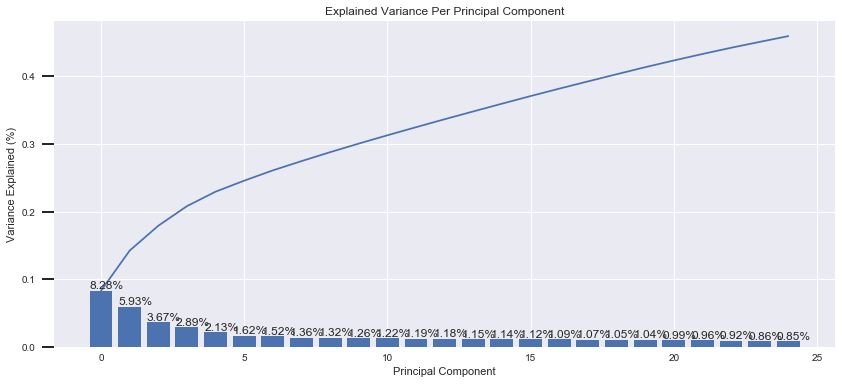

In [53]:
# Investigate the variance accounted for by each principal component.
pca, X_pca = do_pca(25, azdias_scale)
scree_plot(pca)

In [46]:
pca, X_pca = do_pca(20, azdias_scale)
comp_check = pca_results(azdias_new, pca)
print('Using 20 components, we can explain {} of the variability in the original data'.format(comp_check['Explained Variance'].sum()))

Using 20 components, we can explain 0.41240000000000004 of the variability in the original data


### Discussion 2.2: Perform Dimensionality Reduction

104 PCAs can explain over 90% variability in the original dataset. 
84 PCAs can explain over 80% variability in the original dataset. 

However, the general idea of choosing the number of PCA is to select a **stopping point** where additional features do not add much to the amount of variability in the data that is explained. As seen in the graph, I choose to stop at the point when additional variable adds less than 1% variability, which is No.21 PCA (0.93%) from the Variance Graph above. 

Using **20 PCA** components, we can explain 41% of the variability in the original data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, then to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, first map each weight to their corresponding feature name, then sort the features according to weight. Use the data dictionary document to help understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

In [47]:
pca = PCA(20)
X_pca = pca.fit_transform(azdias_scale)
result_PCA = pca_results(azdias_new, pca)
result_PCA.head(3)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_3.0,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,movement,avantgarde,rural,wealth,life_stage
Dimension 1,0.0829,-0.1027,-0.0077,-0.1920,0.1259,-0.0981,0.0645,0.0646,0.1361,-0.1086,0.0305,-0.0226,0.0295,0.0618,0.0874,0.0684,-0.0321,-0.0762,-0.0662,0.0567,0.0794,0.0103,0.0196,0.0330,0.0933,0.0819,-0.0023,-0.0181,-0.0840,-0.0061,0.1787,0.0352,-0.0596,0.1123,0.0248,-0.1297,-0.0299,-0.0475,-0.1896,0.0107,0.1144,0.1242,-0.1785,-0.0922,0.1483,-0.1237,-0.0926,0.0419,-0.2015,-0.0391,0.0635,-0.0627,-0.1787,0.1186,0.1771,0.1712,0.0315,-0.1325,0.1130,0.1511,0.1030,-0.0188,-0.0507,0.0232,0.0249,-0.0013,0.0181,0.1143,-0.0837,-0.0422,0.0115,-0.0022,-0.0297,-0.0167,-0.0077,-0.0177,0.0067,-0.0269,-0.0303,-0.0438,0.0021,0.0039,-0.0047,0.0274,0.0632,0.0856,-0.0333,0.0085,0.0094,0.0020,-0.0006,-0.0091,-0.0220,-0.0034,-0.0440,-0.0466,0.0856,-0.0333,0.0109,-0.0210,-0.0658,0.1252,0.1135,0.0093,-0.0222,-0.0155,-0.0240,-0.0140,-0.0150,-0.1032,-0.1195,0.1920,-0.0154,-0.0280,-0.1041,-0.1195,-0.0630,0.0534,0.0303,-0.0194,0.0097,0.0406,-0.0366

In [48]:
def pca_weight(x):
    print('# {} principal component explained {} of the variability in the original data'.format(x, result_PCA['Explained Variance'].iloc[x-1]))
    print('The top 5 positive and negative values linked values, sorted by weight:')
    print(result_PCA.drop(['Explained Variance'], axis=1).iloc[x-1].transpose().sort_values(ascending=False).head(5))
    print(result_PCA.drop(['Explained Variance'], axis=1).iloc[x-1].transpose().sort_values(ascending=True).head(5))

In [49]:
pca_weight(1)

# 1 principal component explained 0.0829 of the variability in the original data
The top 5 positive and negative values linked values, sorted by weight:
LP_STATUS_GROB_1.0    0.1920
wealth                0.1792
HH_EINKOMMEN_SCORE    0.1787
PLZ8_ANTG3            0.1771
PLZ8_ANTG4            0.1712
Name: Dimension 1, dtype: float64
MOBI_REGIO          -0.2015
FINANZ_MINIMALIST   -0.1920
KBA05_ANTG1         -0.1896
PLZ8_ANTG1          -0.1787
KBA05_GBZ           -0.1785
Name: Dimension 1, dtype: float64


In [50]:
pca_weight(2)

# 2 principal component explained 0.0594 of the variability in the original data
The top 5 positive and negative values linked values, sorted by weight:
ALTERSKATEGORIE_GROB    0.2285
FINANZ_VORSORGER        0.2077
ZABEOTYP_3              0.1995
SEMIO_ERL               0.1827
SEMIO_LUST              0.1578
Name: Dimension 2, dtype: float64
generation              -0.2308
SEMIO_REL               -0.2168
FINANZ_SPARER           -0.2158
SEMIO_PFLICHT           -0.2085
FINANZ_UNAUFFAELLIGER   -0.2076
Name: Dimension 2, dtype: float64


In [51]:
pca_weight(3)

# 3 principal component explained 0.0368 of the variability in the original data
The top 5 positive and negative values linked values, sorted by weight:
ANREDE_KZ     0.3375
SEMIO_VERT    0.3172
SEMIO_FAM     0.2552
SEMIO_SOZ     0.2532
SEMIO_KULT    0.2411
Name: Dimension 3, dtype: float64
SEMIO_KAEM       -0.3072
SEMIO_DOM        -0.2735
SEMIO_KRIT       -0.2575
SEMIO_ERL        -0.1982
FINANZ_ANLEGER   -0.1576
Name: Dimension 3, dtype: float64


In [52]:
pca_weight(4)

# 4 principal component explained 0.029 of the variability in the original data
The top 5 positive and negative values linked values, sorted by weight:
avantgarde             0.2769
GREEN_AVANTGARDE       0.2769
LP_STATUS_FEIN_10.0    0.2282
LP_STATUS_GROB_5.0     0.2282
EWDICHTE               0.2048
Name: Dimension 4, dtype: float64
rural                -0.1872
LP_STATUS_GROB_4.0   -0.1866
LP_STATUS_FEIN_9.0   -0.1786
HH_EINKOMMEN_SCORE   -0.1695
BALLRAUM             -0.1666
Name: Dimension 4, dtype: float64


In [53]:
pca_weight(5)

# 5 principal component explained 0.0214 of the variability in the original data
The top 5 positive and negative values linked values, sorted by weight:
ANZ_PERSONEN            0.3090
LP_FAMILIE_GROB_5.0     0.2749
LP_FAMILIE_FEIN_10.0    0.2078
KKK                     0.1746
LP_FAMILIE_FEIN_11.0    0.1438
Name: Dimension 5, dtype: float64
LP_FAMILIE_GROB_1.0   -0.3516
LP_FAMILIE_FEIN_1.0   -0.3516
W_KEIT_KIND_HH        -0.2325
LP_STATUS_GROB_2.0    -0.1374
PLZ8_GBZ              -0.1176
Name: Dimension 5, dtype: float64


### Discussion 2.3: Interpret Principal Components

The first three PCAs explain **17.91%** of the variability in the original data.

Above results list the main factors donate to the first 3 PCAs. The PCA component is a linear combination by the linked values, and the number beside each feature shown above is the feature weight. A larger weight (either positive or negative) shows the feature is more important in the PCA. For example, PCA 2 here is heavily contributed by generation in the data. 

The dominating features in **PCA1** with **positive** correlations are: low-income earners (LP_STATUS_GROB), wealth, Estimated household net income (HH_EINKOMMEN_SCORE, high to low), number of family houses (PLZ8_ANTG3, PLZ8_ANTG4, 6+houses in the region); with **negative** correlations features: Movement patterns(high to low), low financial interest (FINANZ_MINIMALIST), Number of small family(KBA05_ANTG1,PLZ8_ANTG1), Number of buildings (KBA05_GBZ). PCA1 shows the financial status of family and it's positively related to **low income**. 

The dominating features in **PCA2** with **positive** correlations are: age(ALTERSKATEGORIE_GROB),financially prepared (FINANZ_VORSORGER), fair supplied energy consumption(ZABEOTYP_3), event-oriented/sensual-minded personality (SEMIO_ERL, SEMIO_LUST); with **negative** correlations features: generation(prefer older group), religious/dutiful personality (SEMIO_REL), money-saver/inconspicuous financial typology(FINANZ_SPARER, FINANZ_UNAUFFAELLIGER). PCA2 shows the age preference and certain type of personality, and financial typology. 

The dominating features in **PCA3** with **positive** correlations are: male (ANREDE_KZ), with dreamful/family-minded/socially-minded/cultural-minded personality; with **negative** correlations features: combative attitude/dominant-minded/critical-minded/event-oriented personality, investor financial topology(FINANZ_ANLEGER). PCA3 also explains some personality and financial topology preference, and also shows the gender difference.

**Overall, the first three PCAs mainly capture income status, age, gender, personality and financial typology**

We may also test PCA5 because several most correlated features are over 30% correlation, might be important in explanation. It is strong negatively correlated with LP_FAMILIE_FEIN_0.1, LP_FAMILIE_GROB_1.0 (single), on the other side is positively related to "not single". 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

Apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- First, use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. Use KMeans object's `.score()` method.
- Perform the above two steps for a number of different cluster counts. Check how the average distance decreases with an increasing number of clusters. I use **Elbow Method** ([`link`](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to select K. For each K, there is a Sum of Squared Errors (SSE) score.
> Elbow Method: looks at the percentage of variance explained as a function of the number of clusters, choose a number of clusters so that adding another cluster doesn't give much better modeling of the data

- Once select a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation.

**Reference**
The algorithms behind SSE and other proposed methods (AIC, BIC, etc). [`link`](http://dmkd.cs.vt.edu/papers/kmeans13.pdf)

In [54]:
principalDf = pd.DataFrame(data = X_pca)
principalDf.shape

(623209, 20)

In [55]:
principalDf.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,5.045698,-3.545487,-3.210912,1.110997,0.891224,2.028167,-1.597620,-1.172097,0.099779,1.836260,2.443294,0.006532,1.886309,-0.539804,-0.148045,1.457556,1.006365,-3.654213,-2.186027,0.043021
1,-0.461674,-0.690128,-3.210793,1.656520,-3.778399,0.870914,-1.341098,0.224631,-1.279584,-1.042961,0.243151,-0.370407,0.451691,-2.623139,1.340043,-1.557161,-1.200817,1.951928,-0.347698,-1.746782
2,-0.236679,0.223708,3.048435,0.725078,2.975566,1.329628,-3.571717,3.295292,-1.226100,-3.255960,-1.552008,1.507421,-1.598300,-0.967044,-0.842220,-0.339274,0.266031,0.967862,-1.007588,-0.791556


Over a number of different cluster counts, run k-means clustering on the data and compute the average within-cluster distances.

In [57]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=0)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [58]:
scores = []
centers = list(range(1,20))

for center in centers:
    score = get_kmeans_score(principalDf, center)
    print(score)
    scores.append(score)
print(scores)

49131928.72583445
41584906.488214046
37919907.88349235
35639592.07949619
33877345.68655095
32656380.753010087
31681817.305446226
30734703.706861164
29985163.70917027
29299492.085044146
28781368.672516152
28308537.139667336
27734517.51320725
27332137.843180135
26785677.976131927
26403189.54351082
26080427.903993804
25836969.418718252
25425306.10859761
[49131928.72583445, 41584906.488214046, 37919907.88349235, 35639592.07949619, 33877345.68655095, 32656380.753010087, 31681817.305446226, 30734703.706861164, 29985163.70917027, 29299492.085044146, 28781368.672516152, 28308537.139667336, 27734517.51320725, 27332137.843180135, 26785677.976131927, 26403189.54351082, 26080427.903993804, 25836969.418718252, 25425306.10859761]


In [ ]:
#scores = [49109336.29682307,41561940.876548864,37887845.410983376,35603028.970201455,33825503.470233716,
32603137.608576916,31619264.198557533,30755975.968593102,29901529.4161354,29443548.61169691,
29230926.238428365, 28705910.081203204, 28200561.247170478, 27659891.229581896, 27180806.7875945]
#scores = [52342830.539056912, 44313509.641756251, 40630716.865820378, 37976199.593791619, 36192651.392698094, 
34783758.556663692, 33683560.369488366, 32812914.266902417, 32091481.623309836, 31401523.491611835, 30693908.830671474, 
30082424.908830963, 29647432.323349863, 29138858.320052609, 28737499.773315564, 28379047.089139234, 28269027.044163246, 
27962055.67984746, 27520594.748178411, 27285280.540320709, 26921048.211752221, 26739475.76608501, 26363875.44822238, 
26203223.617825668]

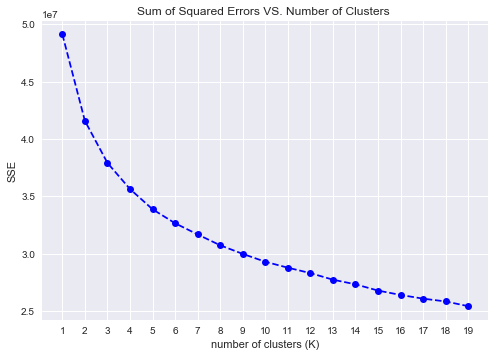

In [76]:
# Save the scores for graphing. 
scores = [49131928.72583445, 41584906.488214046, 37919907.88349235, 35639592.07949619, 33877345.68655095, 32656380.753010087, 31681817.305446226, 30734703.706861164, 29985163.70917027, 29299492.085044146, 28781368.672516152, 28308537.139667336, 27734517.51320725, 27332137.843180135, 26785677.976131927, 26403189.54351082, 26080427.903993804, 25836969.418718252, 25425306.10859761]
centers = list(range(1,20))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xticks(range(1,20));
plt.xlabel('number of clusters (K)');
plt.ylabel('SSE');
plt.title('Sum of Squared Errors VS. Number of Clusters ');

A very small but not obvious elbow at k=5 in the graph. So I choose K=5 as the number of clusters. 

In [77]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters = 5, random_state=0)
preds = model.fit_predict(principalDf)

In [78]:
preds

array([2, 0, 4, ..., 2, 2, 4])

In [79]:
stats.describe(preds)

DescribeResult(nobs=623209, minmax=(0, 4), mean=2.202484238834805, variance=2.091803240493441, skewness=-0.12624310323941546, kurtosis=-1.341340018250625)

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. To use the same fits from the general population to clean, transform, and cluster the customer data. Then I interpreted how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function.
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. Using a `.fit()` or `.fit_transform()` method to re-fit the old objects. Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [80]:
# Load in the customer demographics data.
customers = pd.read_csv("CUSTOMERS_Subset.csv",sep=';')
customers.shape

(191652, 85)

In [81]:
customers_new = clean_data(customers)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, obtaining cluster predictions for the customer demographics data.
Also, I noticed after processing, my customer dataset only has 190 rows, while the population set has 191 rows. Column "GEBAEUDETYP_5.0" is missing. So I make up one in the customer dataset. 

In [82]:
# To save time, use the processed customers data. processing by clean_data(customers)
customers_new['GEBAEUDETYP_5.0'] = 0   # missing one column in customers
customers_new.shape

(115643, 191)

In [83]:
X = scaler.transform(customers_new)
X_pca_cust = pca.transform(X)

In [84]:
principalDf_cust = pd.DataFrame(data = X_pca_cust)

In [85]:
# Choose the same cluster as in the population group
preds_cust = model.predict(principalDf_cust)

In [86]:
preds_cust

array([3, 4, 4, ..., 3, 4, 1])

In [87]:
stats.describe(preds_cust)

DescribeResult(nobs=115643, minmax=(0, 4), mean=2.4434769073787432, variance=1.5072662770021372, skewness=-0.2216233947232332, kurtosis=-1.4757274466283863)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, data based on demographics of the general population of Germany is clustered, and we want to see how the customer data for a mail-order sales company maps onto those demographic clusters. In the final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Steps: 

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations the ratios in cluster representation between groups. (Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html))

- Treat the subset with missing data as an additional data cluster in this analysis. (account for the number of data points in this subset, for both the general population and customer datasets)

- Find out clusters are **overrepresented** in the customer dataset compared to the general population. 

- Use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.

- Perform a similar investigation for the **underrepresented** clusters.

In [88]:
# Missing values in pop and customers
print("In population set, the subset with missing contains {}% total data".format(len(azdias_sub2)/len(azdias)*100))
print("In customers set, the subset with missing contains {}% total data".format(100-len(customers_new)/len(customers)*100))

In population set, the subset with missing contains 30.07245116531141% total data
In customers set, the subset with missing contains 39.6599044100766% total data


In [89]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def plot_cluster(preds,preds_cust,x_PCA):
    len_pop=len(preds)
    len_cust=len(preds_cust)
    pred=[]
    pred_cust=[]
    lst = list(range(0,x_PCA))
    for x in lst:
        pred.append(preds.tolist().count(x)/len_pop)
        pred_cust.append(preds_cust.tolist().count(x)/len_cust)
    
    pred1 = pd.DataFrame(pred,columns={"pred"})
    pred_cust1 = pd.DataFrame(pred_cust,columns={"pred"})
    pred1['label']='population'
    pred_cust1['label']='customer'
    pred1['cluster'] = pred1.index
    pred_cust1['cluster'] = pred_cust1.index
    
    result = pred1.append(pred_cust1)
    sns.barplot(y='pred', x='cluster', data=result, hue='label')

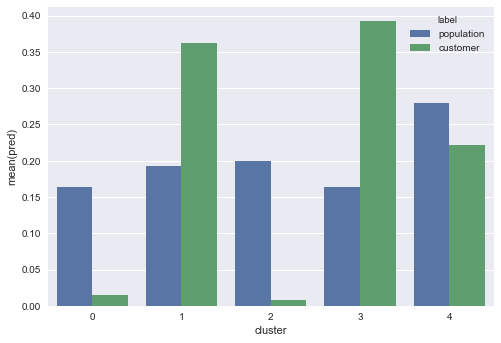

In [92]:
plot_cluster(preds,preds_cust,5)

Cluster 16 compared the missings in the performed sets. Customer dataset had more missing values (39%) than population dataset (30%), and those missing values are quantitively different from those analysed. 

What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population? 
- customers in cluster 1,3.

What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?
- customers in cluster 0,2.

### Examine the impute datasets

In [109]:
print(azdias_imp.shape)
print(customers_imp.shape)

(891221, 194)
(191652, 193)


In [110]:
azdias_imp_list = azdias_imp.columns.values.tolist()
customers_imp_list = customers_imp.columns.values.tolist()

In [111]:
for x in azdias_imp_list:
    if x not in customers_imp_list:
        print(x)

GEBAEUDETYP_5.0


In [113]:
customers_imp['GEBAEUDETYP_5.0'] = 0   # missing one column in customer

In [114]:
print(azdias_imp.shape)
print(customers_imp.shape)
print(customers_new.shape)

(891221, 194)
(191652, 194)
(115643, 191)


In [115]:
customers_new_list = customers_new.columns.values.tolist()
azdias_imp_list = azdias_imp.columns.values.tolist()
customers_imp_list = customers_imp.columns.values.tolist()

In [116]:
drop_lst=[]
for x in azdias_imp_list:
    if x not in customers_new_list:
        drop_lst.append(x)
print(drop_lst)

['GEBAEUDETYP_2.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_6.0']


In [118]:
azdias_imp = azdias_imp.drop(drop_lst,axis=1)
customers_imp = customers_imp.drop(drop_lst,axis=1)

In [119]:
# scaler = StandardScaler()
# pca = PCA(20)
# model = KMeans(n_clusters = 5, random_state=0)

azdias_imp_scale = scaler.transform(azdias_imp)
X_pca_imp = pca.transform(azdias_imp_scale)
principalDf_imp = pd.DataFrame(data = X_pca_imp)
preds_imp = model.predict(principalDf_imp)
preds_imp

array([2, 2, 0, ..., 0, 2, 4])

In [120]:
customers_imp_scale = scaler.transform(customers_imp)
X_pca_imp_cust = pca.transform(customers_imp_scale)
principalDf_imp_cust = pd.DataFrame(data = X_pca_imp_cust)
preds_imp_cust = model.predict(principalDf_imp_cust)
preds_imp_cust

array([3, 3, 4, ..., 3, 4, 1])

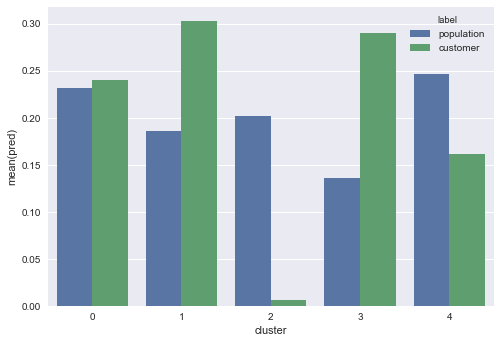

In [122]:
plot_cluster(preds_imp, preds_imp_cust,5)

By fitting the whole datasets with imputated values: 

What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population? 
- customers in cluster 1,3

What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?
- customers in cluster 2.

The only big change occur in cluster 0, from underrepresented in the customer data to overrepresented group. 

#### Notes:
A comparison is made between the general population and customers to identify segments of the population that are central to the sales company's base as well as those that are not.

There are two ways:
-   Centroids Approach: You should know from your work in Step 2.3 how you interpret positive and negative values for at least the first three components. You should look at coefficients with relatively large (positive or negative) magnitude, and interpret them on those scales. If there’s an especially prominent coefficient value beyond the first three components, the you should take a closer look at it, especially if there’s no suggestion on how the cluster should be interpreted from the first three components.

-   An alternative approach you could take is to use the .inverse_transform() method available to both PCA and StandardScaler that can take the transformed data into the scaled values, then scaled values to original values. In this case, check inspected features associated with multiple latent features, rather than just making an interpretation based on a limited number of true dimensions.


In [123]:
centers = model.cluster_centers_
pca_inv = pca.inverse_transform(centers)
scale_inv = scaler.inverse_transform(pca_inv)

In [124]:
ch = pd.DataFrame(scale_inv, columns = azdias_new.columns).round(1)
print(ch.shape)
ch.head(3)

(5, 191)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_3.0,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,generation,movement,avantgarde,rural,wealth,life_stage
0,1.8,0.5,2.6,4.0,2.3,4.1,3.8,2.7,0.2,2.3,2.4,4.5,4.8,5.5,4.7,4.2,3.0,3.4,5.2,5.1,4.1,4.5,3.9,5.8,5.3,0.0,0.5,2.1,-0.0,4.2,3.2,7.6,3.4,0.0,3.6,1992.7,0.9,2.1,1.4,0.4,0.0,3.8,4.9,2.9,5.5,3.9,2.6,3.7,3.8,4.1,695.8,2.8,2.5,1.0,0.3,3.5,3.9,2.7,3.9,2.5,0.0,0.0,0.2,0.4,0.2,0.2,0.5,0.0,0.1,0.2,-0.0,0.2,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.1,0.2,0.1,0.1,0.2,0.4,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.2,0.1,0.4,0.1,0.1,0.1,0.3,-0.0,0.2,0.1,0.2,0.1,0.1,0.0,0.0,0.2,0.1,0.2,0.4,0.1,0.2,0.1,0.8,0.1,0.1,0.3,0.3,0.3,0.1,0.2,0.0,-0.0,0.5,0.2,0.0,0.6,0.2,-0.0,0.2,0.0,0.1,0.2,0.3,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,4.7,0.7,0.2,0.4,2.6,3.2
1,3.4,0.5,4.2,1.7,4.2,2.5,1.8,2.5,0.0,2.2,3.7,3.8,3.4,3.0,3.0,4.3,5.1,5.4,3.6,3.1,4.7,4.3,4.0,3.2,2.8,0.0,0.5,1.9,0.0,4.2,4.3,8.3,2.7,0.0,4.0,1992.8,0.8,2.4,1.2,0.2,0.0,4.1,5.5,

In [125]:
# Top 5 positive or negative features in the first component
PCA1 = ['LP_STATUS_GROB_1.0', 'wealth', 'HH_EINKOMMEN_SCORE', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
        'MOBI_REGIO', 'FINANZ_MINIMALIST', 'KBA05_ANTG1','PLZ8_ANTG1','KBA05_GBZ']

In [126]:
# Top 5 positive or negative features in the second component
PCA2 = ['ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'ZABEOTYP_3', 'SEMIO_ERL','SEMIO_LUST',
        'generation', 'SEMIO_REL', 'FINANZ_SPARER', 'SEMIO_PFLICHT','FINANZ_UNAUFFAELLIGER']

In [127]:
# Top 5 positive or negative features in the third component
PCA3 =['ANREDE_KZ', 'SEMIO_VERT', 'SEMIO_FAM', 'SEMIO_SOZ', 'SEMIO_KULT',
       'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_ERL', 'FINANZ_ANLEGER']

In [128]:
#result_PCA.drop(['Explained Variance'], axis=1).iloc[3-1].transpose().sort_values(ascending=False).head(5).index

In [129]:
popular_lst=[1,3]
unpopular_lst=[0,2]

In [130]:
def feature_compare(PCA1):
    PCA1_df1=pd.DataFrame(ch[PCA1].iloc[popular_lst].mean(axis=0),columns={'mean'})
    PCA1_df2=pd.DataFrame(ch[PCA1].iloc[unpopular_lst].mean(axis=0),columns={'mean'})
    PCA1_df1['label']='popular'
    PCA1_df2['label']='unpopular'
    PCA1_df1['cluster'] = PCA1_df1.index
    PCA1_df2['cluster'] = PCA1_df2.index
    
    PCA1_df = PCA1_df1.append(PCA1_df2)
    sns.barplot(y='cluster', x='mean', data=PCA1_df, hue='label')

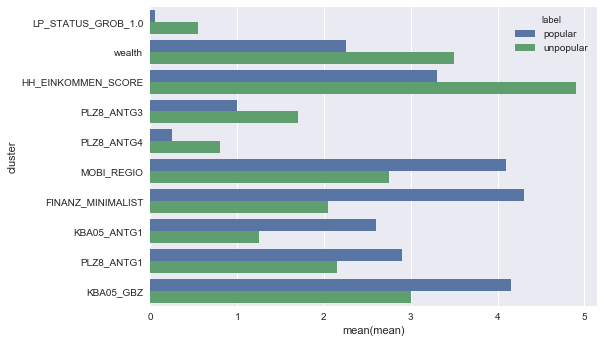

In [131]:
feature_compare(PCA1)

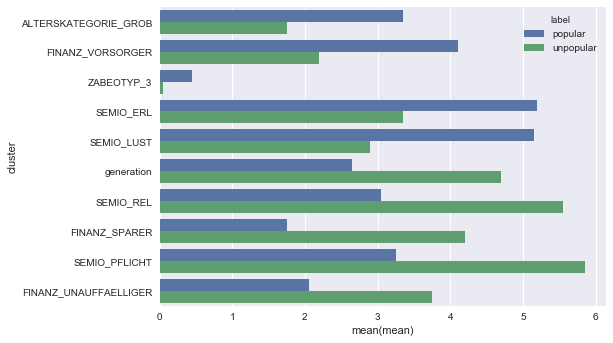

In [132]:
feature_compare(PCA2)

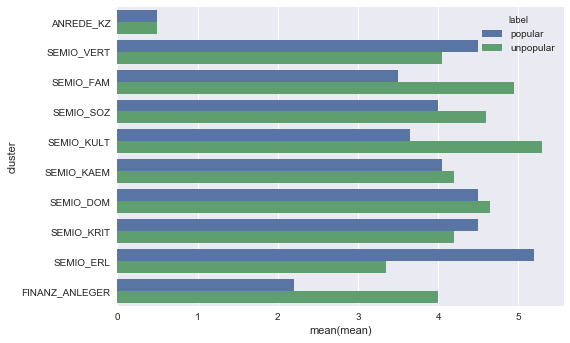

In [133]:
feature_compare(PCA3)

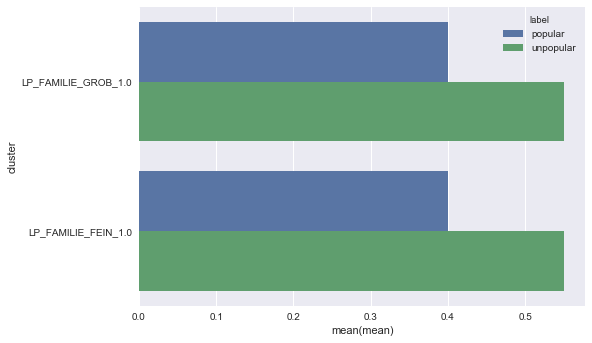

In [134]:
### remind the PCA5 has high correlated with LP_FAMILIE_GROB_1 & LP_FAMILIE_FEIN_1
PCA5=['LP_FAMILIE_GROB_1.0','LP_FAMILIE_FEIN_1.0']
feature_compare(PCA5)

### Discussion 3.3: Compare Customer Data to Demographics Data

The first 5 features in the function of feature_compare are positively related to PCA and the next 5 are negatively. That's why you can find the matitude of popular and unpopular groups change. 

As discussed in Session 2.3, PCA1 is positively correlated with low income. Then in the feature_compare(PCA1) graph, you can find the "unpoluar" group has relatively high low-income index. It suggests the company prefered high income area/family.

Similarly for PCA2, which is positively correlated with elder group with certain personality and financial topology. The popular group are relatively older, low prepared financial topology, event-oriented/sensual-minded personality, not religious/dutiful personality, not money-saver/inconspicuous financial typology. 

We can find in PCA3, the difference between the two group are not so significant. For "being single" in PCA5 is more popular.  

##### Remind Discussion in Session 2.3

The dominating features in **PCA1** with **positive** correlations are: low-income earners (LP_STATUS_GROB), wealth, Estimated household net income (HH_EINKOMMEN_SCORE, high to low), number of family houses (PLZ8_ANTG3, PLZ8_ANTG4, 6+houses in the region); with **negative** correlations features: Movement patterns(high to low), low financial interest (FINANZ_MINIMALIST), Number of small family(KBA05_ANTG1,PLZ8_ANTG1), Number of buildings (KBA05_GBZ). PCA1 shows the financial status of family and it's positively related to **low income**. 

The dominating features in **PCA2** with **positive** correlations are: age(ALTERSKATEGORIE_GROB),financially prepared (FINANZ_VORSORGER), fair supplied energy consumption(ZABEOTYP_3), event-oriented/sensual-minded personality (SEMIO_ERL, SEMIO_LUST); with **negative** correlations features: generation(prefer older group), religious/dutiful personality (SEMIO_REL), money-saver/inconspicuous financial typology(FINANZ_SPARER, FINANZ_UNAUFFAELLIGER). PCA2 shows the age preference and certain type of personality, and financial typology. 

The dominating features in **PCA3** with **positive** correlations are: male (ANREDE_KZ), with dreamful/family-minded/socially-minded/cultural-minded personality; with **negative** correlations features: combative attitude/dominant-minded/critical-minded/event-oriented personality, investor financial topology(FINANZ_ANLEGER). PCA3 also explains some personality and financial topology preference, and also shows the gender difference.

PCA5 is strong negatively correlated with LP_FAMILIE_FEIN_1.0, LP_FAMILIE_GROB_1.0 (single), on the other side is positively related to "not single". 

**Referece**:
- Use [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help navigate to all of the classes and functions that needed.